In this notebook I add weather informations, such as temperature and precipitations, to the training set of the [COVID-19 forecasting competition](https://www.kaggle.com/c/covid19-global-forecasting-week-1/discussion), in order to determine whether there is any correlation with the growth of confirmed cases. Weather data is imported from the [NOAA GSOD dataset](https://www.kaggle.com/noaa/gsod), continuously updated to include recent measurments.

[Data for this and previous weeks is available in dataset form here.](https://www.kaggle.com/davidbnn92/weather-data-for-covid19-data-analysis)

Edit: now missing values are denoted with usual `NaN`s, and not with `9999`s.

Edit 2: information concerning humidity was added, following [brennanmurphy](https://www.kaggle.com/brennanmurphy)'s advice. More specifically, dewpoint temperature was added from the NOAA GSOD dataset, then absolute and relative humidity were computed.

In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

from google.cloud import bigquery

data_path = Path('/kaggle/input/covid19-global-forecasting-week-1/')
train = pd.read_csv(data_path / 'train.csv')
test = pd.read_csv(data_path / 'test.csv')

data_path = Path('/kaggle/input/covid19-global-forecasting-week-4/')
train_2 = pd.read_csv(data_path / 'train.csv')
test_2 = pd.read_csv(data_path / 'test.csv')

/kaggle/input
/kaggle/input/covid19-global-forecasting-week-4
/kaggle/input/covid19-global-forecasting-week-1
/kaggle/input/covid19-global-forecasting-week-2
/kaggle/input/covid19-global-forecasting-week-3


There are 184 different nations in the training dataset.
184 of these nations have confirmed cases of COVID-19.
In 150 of these nations, people have died of COVID-19.


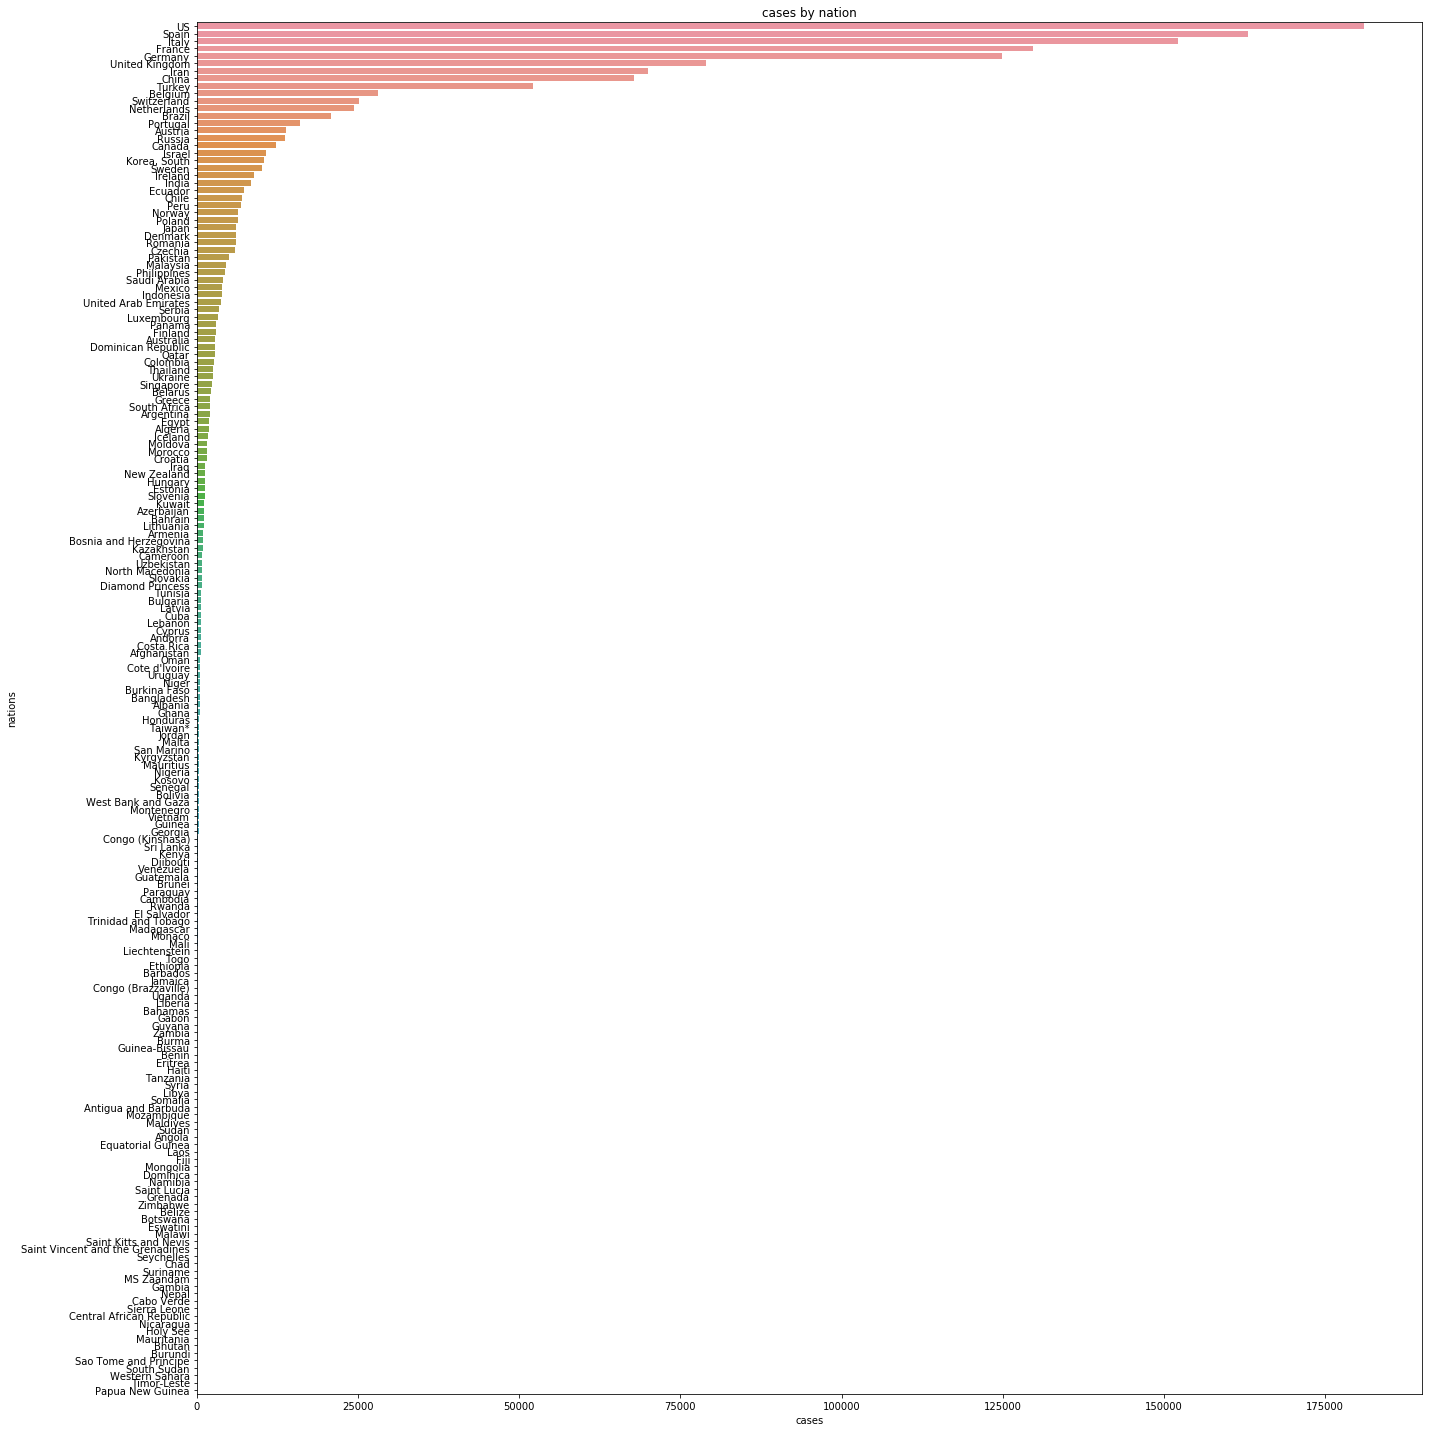

In [2]:
x = len([nation for nation in train_2['Country_Region'].unique()])
print("There are {} different nations in the training dataset.".format(x))

s = train_2.groupby('Country_Region').ConfirmedCases.max()
nations_cases = [x for x in s.index if s[x]]
print("{} of these nations have confirmed cases of COVID-19.".format(len(nations_cases)))

s_2 = train_2.groupby('Country_Region').Fatalities.max()
nations_deaths = [x for x in s_2.index if s_2[x]]
print("In {} of these nations, people have died of COVID-19.".format(len(nations_deaths)))

barplot_df = pd.DataFrame({
    'nations': nations_cases,
    'cases': [s[x] for x in s.index if s[x]]
})
plt.figure(figsize=(20, 20))
sns.barplot(x="cases", y="nations", data=barplot_df.sort_values(by='cases', ascending=False))
plt.title('cases by nation')
plt.tight_layout()
plt.show()

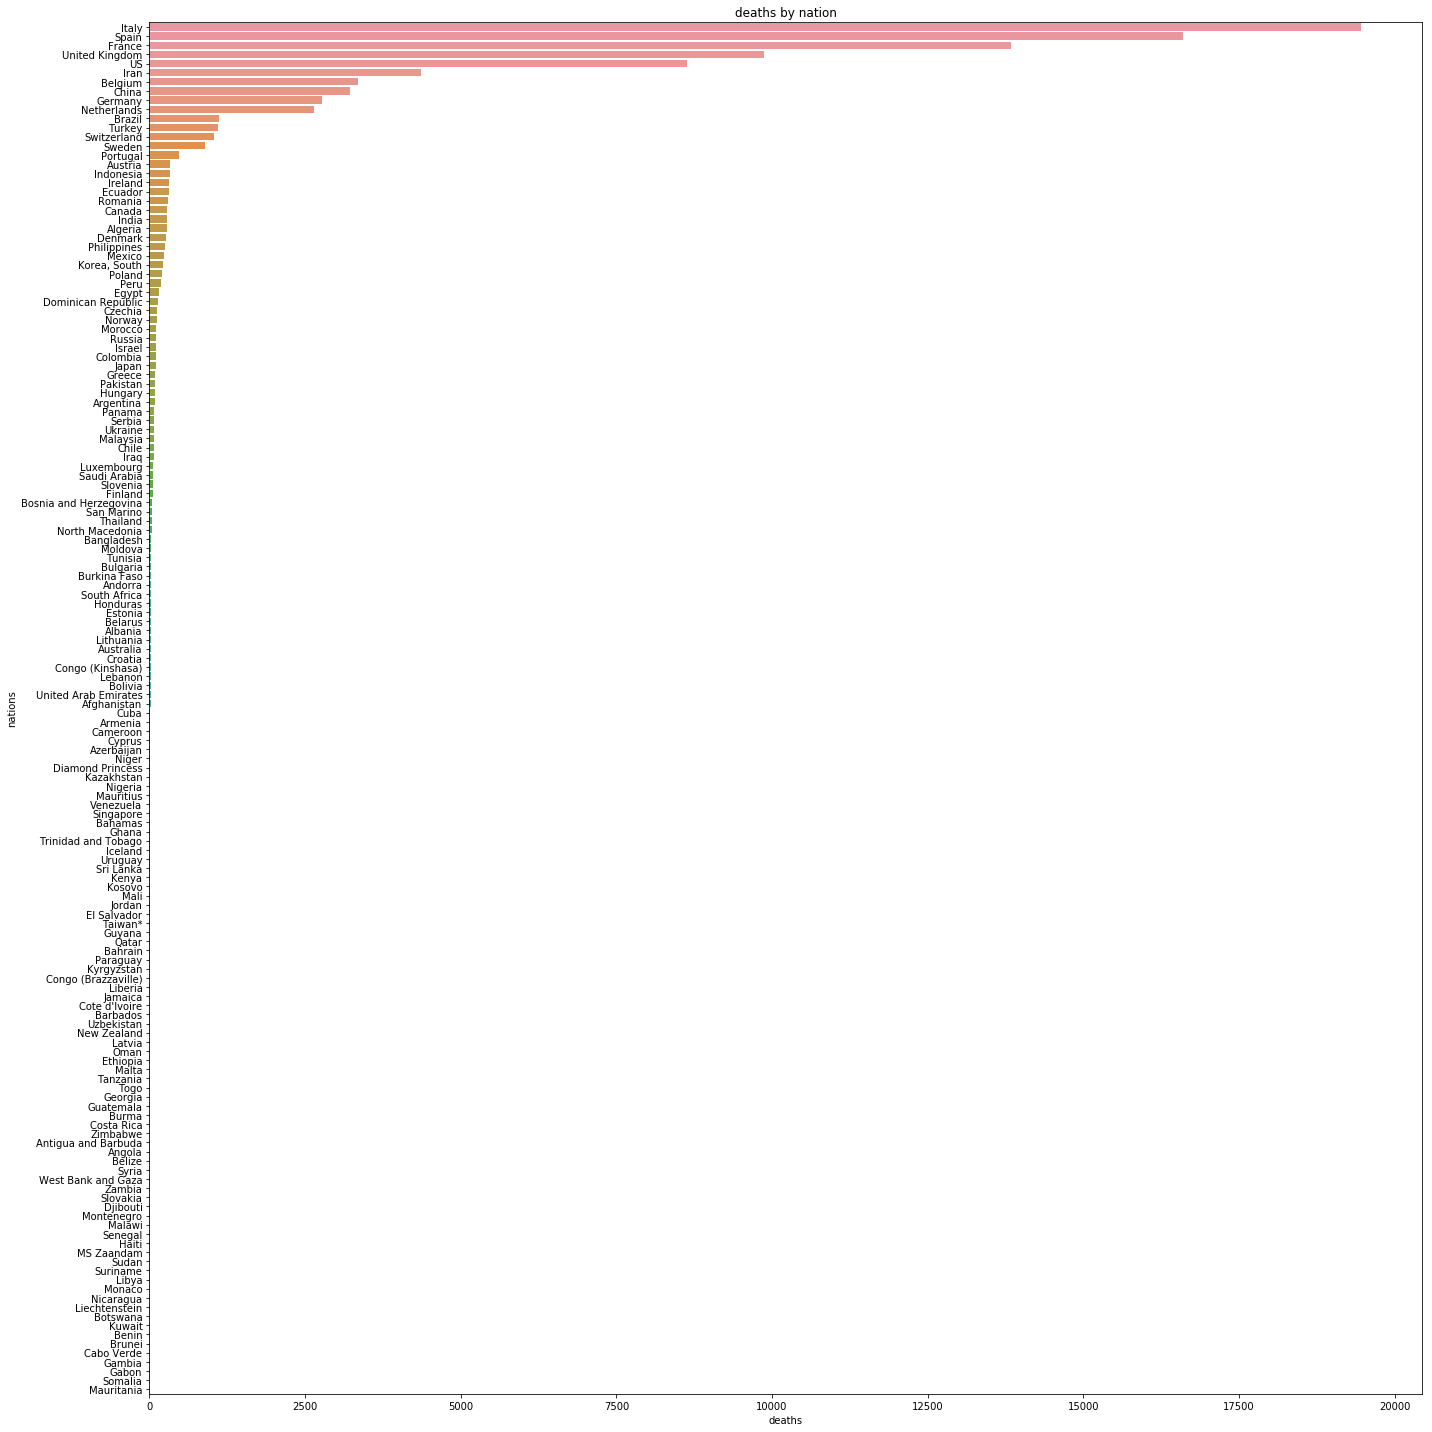

In [3]:
barplot_df = pd.DataFrame({
    'nations': nations_deaths,
    'deaths': [s_2[x] for x in s_2.index if s_2[x]]
})
plt.figure(figsize=(20, 20))
sns.barplot(x="deaths", y="nations", data=barplot_df.sort_values(by='deaths', ascending=False))
plt.title('deaths by nation')
plt.tight_layout()
plt.show()

Here is the weather data:
* `temp`: Mean temperature for the day in degrees Fahrenheit to tenths.
* `max`: Maximum temperature reported during the day in Fahrenheit to tenths--time of max temp report varies by country and region, so this will sometimes not be the max for the calendar day.
* `min`: Minimum temperature reported during the day in Fahrenheit to tenths--time of min temp report varies by country and region, so this will sometimes not be the min for the calendar day.
* `stp`: Mean station pressure for the day in millibars to tenths.
* `slp`: Mean sea level pressure for the day in millibars to tenths.
* `dewp`: Mean dew point for the day in degrees Fahrenheit to tenths. 
* `wdsp`: Mean wind speed for the day in knots to tenths.
* `prcp`: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation--i.e., may include latter part of previous day. .00 indicates no measurable precipitation (includes a trace).
* `fog`: Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day

In [4]:
client = bigquery.Client()
dataset_ref = client.dataset("noaa_gsod", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))

table_ref = dataset_ref.table("stations")
table = client.get_table(table_ref)
stations_df = client.list_rows(table).to_dataframe()

table_ref = dataset_ref.table("gsod2020")
table = client.get_table(table_ref)
twenty_twenty_df = client.list_rows(table).to_dataframe()

stations_df['STN'] = stations_df['usaf'] + '-' + stations_df['wban']
twenty_twenty_df['STN'] = twenty_twenty_df['stn'] + '-' + twenty_twenty_df['wban']

cols_1 = ['STN', 'mo', 'da', 'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'wdsp', 'prcp', 'fog']
cols_2 = ['STN', 'country', 'state', 'call', 'lat', 'lon', 'elev']
weather_df = twenty_twenty_df[cols_1].join(stations_df[cols_2].set_index('STN'), on='STN')

weather_df['temp'] = weather_df['temp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['max'] = weather_df['max'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['min'] = weather_df['min'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['stp'] = weather_df['stp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['slp'] = weather_df['slp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['dewp'] = weather_df['dewp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['wdsp'] = weather_df['wdsp'].apply(lambda x: np.nan if x==999.9 else x)
weather_df['prcp'] = weather_df['prcp'].apply(lambda x: np.nan if x==99.9 else x)

display(weather_df.tail(10))
weather_df.info(verbose=True)

Using Kaggle's public dataset BigQuery integration.


,STN,mo,da,temp,min,max,stp,slp,dewp,wdsp,prcp,fog,country,state,call,lat,lon,elev
1144417,999999-00458,01,04,42.6,33.8,51.3,980.0,NaN,41.6,6.5,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144418,999999-00458,01,18,38.3,32.0,51.3,989.2,NaN,31.7,8.5,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144419,999999-00458,01,24,42.2,38.5,46.8,983.6,NaN,37.4,4.9,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144420,999999-00458,02,04,58.7,42.3,63.3,979.3,NaN,47.3,8.1,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144421,999999-00458,02,06,33.5,31.6,34.7,970.9,NaN,33.0,5,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144422,999999-00458,02,08,30.4,26.6,34.9,988.3,NaN,27.2,4.7,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144423,999999-00458,02,10,45.0,40.1,48.4,986.9,NaN,41.4,7.7,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144424,999999-00458,02,24,43.6,40.1,50.2,985.0,NaN,32.9,3.8,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144425,999999-00458,02,25,43.6,42.1,46.0,976.6,NaN,43.5,2.9,99.99,1,US,OH,None,39.078,-84.21,+0257.0
1144426,999999-00458,03,06,41.6,35.6,52.2,987.3,NaN,29.2,11.4,99.99,1,US,OH,None,39.078,-84.21,+0257.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144427 entries, 0 to 1144426
Data columns (total 18 columns):
STN        1144427 non-null object
mo         1144427 non-null object
da         1144427 non-null object
temp       1144427 non-null float64
min        1143659 non-null float64
max        1143649 non-null float64
stp        1144427 non-null float64
slp        757646 non-null float64
dewp       1087383 non-null float64
wdsp       1144427 non-null object
prcp       1144427 non-null float64
fog        1144427 non-null object
country    987879 non-null object
state      263050 non-null object
call       521311 non-null object
lat        987879 non-null float64
lon        987879 non-null float64
elev       987879 non-null object
dtypes: float64(9), object(9)
memory usage: 157.2+ MB


Now let's compute absolute and relative humidity from temperature and dew point:

In [5]:
# convert everything into celsius
temp = (weather_df['temp'] - 32) / 1.8
dewp = (weather_df['dewp'] - 32) / 1.8
    
# compute relative humidity as ratio between actual vapour pressure (computed from dewpoint temperature)
# and saturation vapour pressure (computed from temperature) (the constant 6.1121 cancels out)
weather_df['rh'] = (np.exp((18.678*dewp)/(257.14+dewp))/np.exp((18.678*temp)/(257.14+temp)))

# calculate actual vapour pressure (in pascals)
# then use it to compute absolute humidity from the gas law of vapour 
# (ah = mass / volume = pressure / (constant * temperature))
weather_df['ah'] = ((np.exp((18.678*dewp)/(257.14+dewp))) * 6.1121 * 100) / (461.5 * temp)

# Week 1:

In [6]:
weather_df['day_from_jan_first'] = (weather_df['da'].apply(int)
                                   + 31*(weather_df['mo']=='02') 
                                   + 60*(weather_df['mo']=='03')
                                   + 91*(weather_df['mo']=='04')  
                                   )

mo = train['Date'].apply(lambda x: x[5:7])
da = train['Date'].apply(lambda x: x[8:10])
train['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )

C = []
for j in train.index:
    df = train.iloc[j:(j+1)]
    mat = cdist(df[['Lat','Long', 'day_from_jan_first']],
                weather_df[['lat','lon', 'day_from_jan_first']], 
                metric='euclidean')
    new_df = pd.DataFrame(mat, index=df.Id, columns=weather_df.index)
    arr = new_df.values
    new_close = np.where(arr == np.nanmin(arr, axis=1)[:,None],new_df.columns,False)
    L = [i[i.astype(bool)].tolist()[0] for i in new_close]
    C.append(L[0])
    
train['closest_station'] = C

train = train.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
train.sort_values(by=['Id'], inplace=True)
train.index = train['Id'].apply(lambda x: x-1)
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,day_from_jan_first,temp,min,max,stp,slp,dewp,rh,ah,wdsp,prcp,fog
Id,,,,,,,,,,,,,,,,,,,,
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,22,42.6,33.6,54.9,999.9,1024.3,27.4,0.545709,0.186448,9.4,0.00,0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,23,42.0,32.7,55.9,999.9,1020.8,22.8,0.461259,0.163225,14.9,99.99,1
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,24,40.1,36.9,43.2,999.9,1018.6,34.5,0.801794,0.325375,10.4,0.17,1
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,25,46.0,37.9,56.3,999.9,1018.0,37.8,0.728175,0.214562,6.1,0.57,1
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,26,42.8,36.1,53.1,999.9,1014.8,33.2,0.685513,0.231656,10.8,0.00,1


In [7]:
train.to_csv('training_data_with_weather_info_week_1.csv', index=False)

# Week 2:

See commit no. 16.

# Week 3:

See commit no. 21.

# Week 4:

In [8]:
display(train_2.head())
#display(test_2.head())

# Create cross feature country + province
train['country+province'] = train['Country/Region'].fillna('') + '-' + train['Province/State'].fillna('')
train_2['country+province'] = train_2['Country_Region'].fillna('') + '-' + train_2['Province_State'].fillna('')

# Conversion table to add coordinates for regions that weren't in week 1's dataset
df = train.groupby('country+province')[['Lat', 'Long']].mean()
df.loc['United Kingdom-'] = df.loc['United Kingdom-United Kingdom']
df.loc['Diamond Princess-'] = df.loc['Cruise Ship-Diamond Princess']
df.loc['Denmark-'] = df.loc['Denmark-Denmark']
df.loc['France-'] = df.loc['France-France']
df.loc['Gambia-'] = df.loc['Gambia, The-']
df.loc['Netherlands-'] = df.loc['Netherlands-Netherlands']
df.loc['Dominica-'] = (15.3, -61.383333)
df.loc['Angola-'] = (-8.830833, 13.245)
df.loc['Bahamas-'] = (25.066667, -77.333333)
df.loc['Belize-'] = (17.498611, -88.188611)
df.loc['Cabo Verde-'] = (14.916667, -23.516667)
df.loc['Chad-'] = (12.134722, 15.055833)
df.loc['Denmark-Greenland'] = (64.181389, -51.694167)
df.loc['El Salvador-'] = (13.698889, -89.191389)
df.loc['Eritrea-'] = (15.322778, 38.925)
df.loc['Fiji-'] = (-18.166667, 178.45)
df.loc['France-Martinique'] = (14.666667, -61)
df.loc['France-New Caledonia'] = (-22.2758, 166.458)
df.loc['Grenada-'] = (12.05, -61.75)
df.loc['Guinea-Bissau-'] = (11.85, -15.566667)
df.loc['Haiti-'] = (18.533333, -72.333333)
df.loc['Laos-'] = (17.966667, 102.6)
df.loc['Libya-'] = (32.887222, 13.191389)
df.loc['Madagascar-'] = (-18.933333, 47.516667)
df.loc['Mali-'] = (12.639167, -8.002778)
df.loc['Mozambique-'] = (-25.966667, 32.583333)
df.loc['Netherlands-Sint Maarten'] = (18.052778, -63.0425)
df.loc['Nicaragua-'] = (12.136389, -86.251389)
df.loc['Niger-'] = (13.511667, 2.125278)
df.loc['Papua New Guinea-'] = (-9.478889, 147.149444)
df.loc['Saint Kitts and Nevis-'] = (17.3, -62.733333)
df.loc['Syria-'] = (33.513056, 36.291944)
df.loc['Timor-Leste-'] = (-8.566667, 125.566667)
df.loc['Uganda-'] = (0.313611, 32.581111)
df.loc['Zimbabwe-'] = (-17.829167, 31.052222)
df.loc['United Kingdom-Bermuda'] = (32.293, -64.782)
df.loc['United Kingdom-Isle of Man'] = (54.145, -4.482)

df.loc['Botswana-'] = (-24.658056, 25.912222)
df.loc['Burma-'] = (16.85, 96.183333)
df.loc['Burundi-'] = (-3.383333, 29.366667)
df.loc['Canada-Northwest Territories'] = (62.442222, -114.394722)
df.loc['Canada-Yukon'] = (60.716667, -135.05)
df.loc['Kosovo-'] = (42.666667, 21.166667)
df.loc['MS Zaandam-'] = (26.086111, -80.115278)
df.loc['Sierra Leone-'] = (8.484444, -13.234444)
df.loc['United Kingdom-Anguilla'] = (18.220833, -63.051667)
df.loc['United Kingdom-British Virgin Islands'] = (18.431389, -64.623056)
df.loc['United Kingdom-Turks and Caicos Islands'] = (21.783333, -72.283333)
df.loc['West Bank and Gaza-'] = (31.703056, 35.195556)

df.loc['France-Saint Pierre and Miquelon'] = (46.7778, -56.1778)
df.loc['Malawi-'] = (-13.983333, 33.783333)
df.loc['Netherlands-Bonaire, Sint Eustatius and Saba'] = (12.144444, -68.265556)
df.loc['Sao Tome and Principe-'] = (0.336111, 6.730556)
df.loc['South Sudan-'] = (4.85, 31.6)
df.loc['United Kingdom-Falkland Islands (Malvinas)'] = (-51.694444, -57.852778)
df.loc['Western Sahara-'] = (27.153611, -13.203333)
 
# add latitudes and longitudes to new dataframe
train_2['Lat'] = train_2['country+province'].apply(lambda x: df.loc[x, 'Lat'])
train_2['Long'] = train_2['country+province'].apply(lambda x: df.loc[x, 'Long'])

# compute closest weather station, as done for week 1
mo = train_2['Date'].apply(lambda x: x[5:7])
da = train_2['Date'].apply(lambda x: x[8:10])
train_2['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )

C = []
for j in train_2.index:
    df = train_2.iloc[j:(j+1)]
    mat = cdist(df[['Lat','Long', 'day_from_jan_first']],
                weather_df[['lat','lon', 'day_from_jan_first']], 
                metric='euclidean')
    new_df = pd.DataFrame(mat, index=df.Id, columns=weather_df.index)
    arr = new_df.values
    new_close = np.where(arr == np.nanmin(arr, axis=1)[:,None],new_df.columns,False)
    L = [i[i.astype(bool)].tolist()[0] for i in new_close]
    C.append(L[0])
    
train_2['closest_station'] = C

# add weather observations from closest station
train_2= train_2.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
train_2.sort_values(by=['Id'], inplace=True)
train_2.index = train_2['Id'].apply(lambda x: x-1)
display(train_2.head())

# output
train_2.to_csv('training_data_with_weather_info_week_4.csv', index=False)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country+province,Lat,Long,day_from_jan_first,...,min,max,stp,slp,dewp,rh,ah,wdsp,prcp,fog
Id,,,,,,,,,,,,,,,,,,,,,
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,Afghanistan-,33.0,65.0,22,...,33.6,54.9,999.9,1024.3,27.4,0.545709,0.186448,9.4,0.00,0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,Afghanistan-,33.0,65.0,23,...,32.7,55.9,999.9,1020.8,22.8,0.461259,0.163225,14.9,99.99,1
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,Afghanistan-,33.0,65.0,24,...,36.9,43.2,999.9,1018.6,34.5,0.801794,0.325375,10.4,0.17,1
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,Afghanistan-,33.0,65.0,25,...,37.9,56.3,999.9,1018.0,37.8,0.728175,0.214562,6.1,0.57,1
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,Afghanistan-,33.0,65.0,26,...,36.1,53.1,999.9,1014.8,33.2,0.685513,0.231656,10.8,0.00,1
